# GAN for Patterns of Nature

Train a GAN to generate images of patterns found in nature.

In [2]:
# import
import tensorflow as tf
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import paths
import math
import time

## Dataset

Dataset was scraped from Google Images under the query of 'nature patterns'. The Google Chrome Fatkun Batch Image Download extension was used. Downloaded images can be gound in `nature_patterns_images` directory.

### Preprocess - resize
Preprocess image dataset by resizing all images to the same size.

In [3]:
# image_dir = "dataset/nature_patterns_images/"
# save_dir = 'dataset/resized/'

# for item in os.listdir(image_dir):
#     filepath = os.path.join(image_dir, item)
#     if os.path.isfile(filepath):
#         im = Image.open(filepath).convert('RGB')
#         f, e = os.path.splitext(os.path.basename(filepath))
        
#         imResize = im.resize((200, 200), Image.ANTIALIAS)
#         save_path = os.path.join(save_dir, f + '.jpg')
#         imResize.save(save_path, 'JPEG', quality=90)

### Load and prepare dataset

In [4]:
dataset = 'dataset/resized/'
imagePaths = list(paths.list_images(dataset))

trainImages = np.empty([len(imagePaths), 200, 200, 3])

# load images into numpy array
for i in range(len(imagePaths)):
    im = Image.open(imagePaths[i])
    np_im = np.asarray(im)
    trainImages[i] = np_im

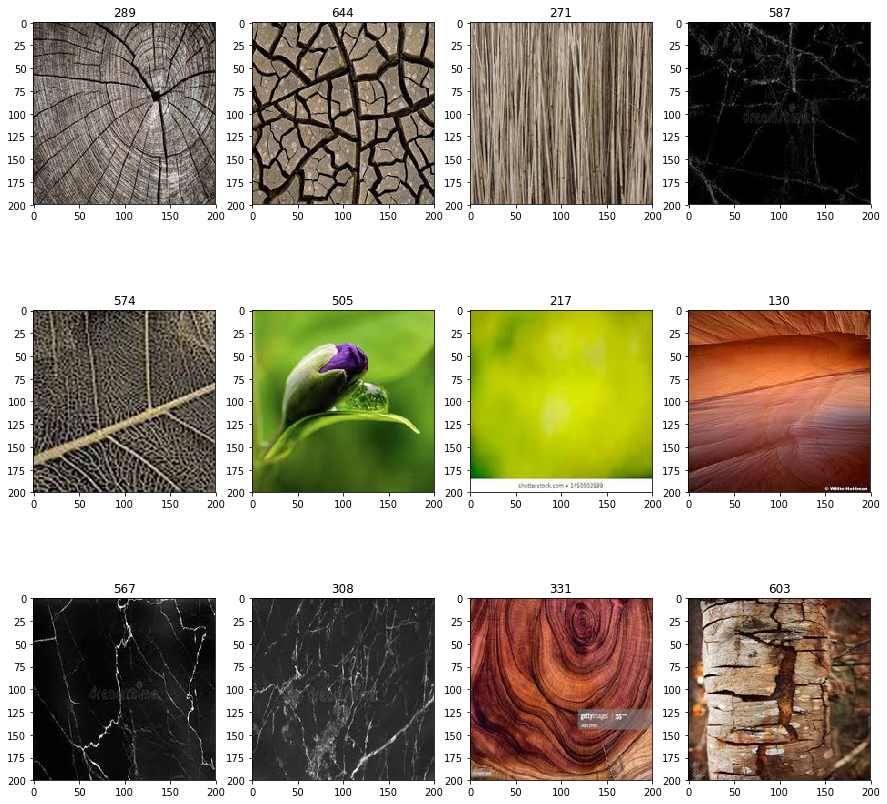

In [5]:
# preview images
preview_n = 12
previews = np.random.choice(len(trainImages), preview_n)

fig = plt.figure(figsize=(15,15))
columns = 4
rows = math.ceil(preview_n/columns)

for i in range(1, preview_n + 1):
    np_im_preview = trainImages[previews[i-1]]
    im_preview = Image.fromarray((np_im_preview).astype(np.uint8))
    fig.add_subplot(rows, columns, i).set_title(previews[i-1])
    plt.imshow(im_preview)

In [6]:
# normalize images
trainImages = trainImages.reshape(trainImages.shape[0], 200, 200, 3).astype('float32')
trainImages = (trainImages - 127.5) / 127.5

In [7]:
BUFFER_SIZE = len(imagePaths)
BATCH_SIZE = 32

In [8]:
# batch and shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices(trainImages).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Implementing DCGAN


In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape

class DCGAN:
	@staticmethod
	def build_generator(dim, depth, channels=3, inputDim=100,
		outputDim=512):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (dim, dim, depth)
		chanDim = -1

		# first set of FC => RELU => BN layers
		model.add(Dense(input_dim=inputDim, units=outputDim))
		model.add(Activation("relu"))
		model.add(BatchNormalization())

		# second set of FC => RELU => BN layers, this time preparing
		# the number of FC nodes to be reshaped into a volume
		model.add(Dense(dim * dim * depth))
		model.add(Activation("relu"))
		model.add(BatchNormalization())

		# reshape the output of the previous layer set, upsample +
		# apply a transposed convolution, RELU, and BN
		model.add(Reshape(inputShape))
		model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
			padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))

		# apply another upsample and transposed convolution, but
		# this time output the TANH activation
		model.add(Conv2DTranspose(channels, (5, 5), strides=(2, 2),
			padding="same"))
		model.add(Activation("tanh"))

		# return the generator model
		return model

	@staticmethod
	def build_discriminator(width, height, depth, alpha=0.2):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# first set of CONV => RELU layers
		model.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
			input_shape=inputShape))
		model.add(LeakyReLU(alpha=alpha))

		# second set of CONV => RELU layers
		model.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
		model.add(LeakyReLU(alpha=alpha))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(LeakyReLU(alpha=alpha))

		# sigmoid layer outputting a single value
		model.add(Dense(1))
		model.add(Activation("sigmoid"))

		# return the discriminator model
		return model


/home/kwan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Training a DCGAN

In [3]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from imutils import build_montages


In [4]:
NUM_EPOCHS = 50

In [ ]:
# build generator
gen = DCGAN.build_generator(1, 32, channels=1)